In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
from torchsummary import summary
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Structure: 

![STRUCTURE](/home/ocr/teluguOCR/Structure.webp) 

Hyper parameters of the whole structure

In [2]:
# original_text_size = 175

# out look of the model
Number_of_images = 1000
Image_size = (32, 32) # (height, width)
Image_embedding_size = 50
Text_embedding_size = 7
Max_Number_of_Words = 350

batch_size = 50

# Joiner Embedder parameters
Joiner_Input_size = Text_embedding_size #175
Joiner_output_size = Image_embedding_size #50

# LSTM parameters for the RNN
LSTM_Input_size = Joiner_output_size #50
LSTM_hidden_size = LSTM_Input_size #50
LSTM_num_layers = 1
LSTM_output_size = LSTM_hidden_size #50

# reverse Embedding parameters
Reverse_Input_size = LSTM_output_size #50
Reverse_output_size = Text_embedding_size #175

drop_prob = 0.3

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms

class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.to(device)
        self.resnet.eval()        

        self.fc = nn.Linear(1000, Image_embedding_size)
    def forward(self, x):
        x = self.resnet(x)
        x = F.leaky_relu( self.fc(x), negative_slope = 0.2)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.01)
        return optimizer


In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class EncoderCNN(nn.Module):
    def __init__(self) -> None:
        super(EncoderCNN, self).__init__()
        # input: 32x32
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)  # 30x30x64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  # 30x30x64
        self.BatchNorm1 = nn.BatchNorm2d(64, momentum=0.1)
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 15x15x64
        self.dropout1 = nn.Dropout2d(p=drop_prob)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 15x15x128
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)  # 15x15x128
        self.BatchNorm2 = nn.BatchNorm2d(128, momentum=0.1)
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2, stride=(2, 1))  # 7x14x128
        self.dropout2 = nn.Dropout2d(p=drop_prob)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # 7x14x256
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)  # 7x14x256
        self.BatchNorm3 = nn.BatchNorm2d(256, momentum=0.1)
        self.MaxPool3 = nn.MaxPool2d(kernel_size=2, stride=(2, 1))  # 3x13x256
        self.dropout3 = nn.Dropout2d(p=drop_prob)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)  # 3x13x512
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)  # 3x13x512
        self.BatchNorm4 = nn.BatchNorm2d(512, momentum=0.1)
        self.MaxPool4 = nn.MaxPool2d(kernel_size=3, stride=(3, 1))  # 1x11x512
        self.dropout4 = nn.Dropout2d(p=drop_prob)

        # Assuming Image_embedding_size is the output size of the linear layer
        self.Dense = nn.Sequential(
            nn.Linear(1 * 11 * 512, 2500),
            nn.ReLU(),
            nn.Linear(2500, 1750),
            nn.ReLU(),
            nn.Linear(1750, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, Image_embedding_size))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.BatchNorm1(F.relu(self.conv2(x)))
        x = self.MaxPool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = self.BatchNorm2(F.relu(self.conv4(x)))
        x = self.MaxPool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = self.BatchNorm3(F.relu(self.conv6(x)))
        x = self.MaxPool3(x)
        x = self.dropout3(x)

        x = F.relu(self.conv7(x))
        x = self.BatchNorm4(F.relu(self.conv8(x)))
        x = self.MaxPool4(x)
        x = self.dropout4(x)

        # Reshape before passing through linear layers
        x = x.view(x.size(0), -1)
        x = self.Dense(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.01)
        return optimizer


In [5]:
class Network(nn.Module):
    def __init__(self) -> None:
        super(Network, self).__init__()
        
        # embedding layer sizes
        self.einput_size = Joiner_Input_size #175
        self.eoutput_size = Joiner_output_size #50
        
        # LSTM parameters
        self.embed_size = LSTM_Input_size #50
        self.hidden_size = LSTM_hidden_size #50
        self.num_layers = LSTM_num_layers #1
        
        # reverse embedding layer sizes
        self.Rinput_size = Reverse_Input_size #50
        self.Routput_size = Reverse_output_size #175

        # dense embedding layers from 175 to 20
        self.embedding1 = nn.Linear(self.einput_size, self.eoutput_size, bias=False)
        
        # LSTM layer
        self.lstm1 = nn.LSTM(input_size = self.embed_size, hidden_size = 100, num_layers = self.num_layers, bidirectional = True, batch_first=True) #50 to 200
        self.lstm2 = nn.LSTM(input_size = 200, hidden_size = 200, num_layers = self.num_layers, bidirectional = True, batch_first=True) #200 to 400
        self.lstm3 = nn.LSTM(input_size = 400, hidden_size = 100, num_layers = self.num_layers, bidirectional = True, batch_first=True) #400 to 200
        self.lstm4 = nn.LSTM(input_size = 200, hidden_size = 50, num_layers = self.num_layers, bidirectional = True, batch_first=True) #200 to 100
        self.lstm5 = nn.LSTM(input_size = 100, hidden_size = 25, num_layers = self.num_layers, bidirectional = True, batch_first=True) #100 to 50

        # attention layers for the LSTM
        self.attention_Q = nn.Linear(self.Rinput_size, self.Rinput_size)
        self.attention_K = nn.Linear(self.Rinput_size, self.Rinput_size)
        self.attention_V = nn.Linear(self.Rinput_size, self.Rinput_size)

        # dense layers from 20 to 175
        self.Dense1 = nn.Linear(self.Rinput_size, self.Routput_size, bias=False)

        # initialise the weights of the embedding layers
        self.embedding1.weight.data.uniform_(999, 1001)
        self.Dense1.weight.data.uniform_(999, 1001)

        self.relu = nn.ReLU()
        
        

    def init_hidden(self, batch_size):
        return ((torch.zeros(2*self.num_layers, batch_size, 100).to(device),
                torch.zeros(2*self.num_layers, batch_size, 100).to(device)),

                (torch.zeros(2*self.num_layers, batch_size, 200).to(device),
                torch.zeros(2*self.num_layers, batch_size, 200).to(device)),

                (torch.zeros(2*self.num_layers, batch_size, 100).to(device),
                torch.zeros(2*self.num_layers, batch_size, 100).to(device)),

                (torch.zeros(2*self.num_layers, batch_size, 50).to(device),
                torch.zeros(2*self.num_layers, batch_size, 50).to(device)),

                (torch.zeros(2*self.num_layers, batch_size, 25).to(device),
                torch.zeros(2*self.num_layers, batch_size, 25).to(device)))
    

    def forward(self, images, labels):

        # embedding layers
        word_embed = self.embedding1(labels)

        embeddings = torch.cat((images.unsqueeze(1), word_embed), dim=1)

        batch_size = labels.shape[0]

        self.hidden1, self.hidden2, self.hidden3, self.hidden4, self.hidden5 = self.init_hidden(batch_size)

        # LSTM layer
        LSTM_out, self.hidden1 = self.lstm1(embeddings, self.hidden1)
        LSTM_out = self.relu(LSTM_out)
        LSTM_out, self.hidden2 = self.lstm2(LSTM_out, self.hidden2)
        LSTM_out, self.hidden3 = self.lstm3(LSTM_out, self.hidden3)
        LSTM_out = self.relu(LSTM_out)
        LSTM_out, self.hidden4 = self.lstm4(LSTM_out, self.hidden4)
        LSTM_out, self.hidden5 = self.lstm5(LSTM_out, self.hidden5)
        LSTM_out = self.relu(LSTM_out)
        # print(LSTM_out.shape)

        # attention layers
        Q = self.attention_Q(LSTM_out)
        K = self.attention_K(LSTM_out)
        V = self.attention_V(LSTM_out)
        attention = torch.matmul(Q, K.transpose(1, 2))
        attention = F.softmax(attention, dim=2)
        attention = torch.matmul(attention, V)

        attention = F.log_softmax(attention, dim=2)

        # dense layers for reverse embedding
        outputs = self.Dense1(attention)
        return outputs

In [6]:
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F

# class EncoderCNN(nn.Module):
#     def __init__(self):
#         super(EncoderCNN, self).__init__()
        
#         # Convolutional layers
#         # input size: (batch_size, 1, 300, 300)
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
#         self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        
#         self.relu = nn.LeakyReLU(negative_slope = 0.2)
#         # Pooling layers
#         self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

#         # Fully connected layers
#         self.fc1 = nn.Linear(512 * 9 * 9, 4096)
#         self.fc2 = nn.Linear(4096, 2048)
#         self.fc3 = nn.Linear(2048, Image_embedding_size)

#     def forward(self, x):
#         # Input size: (batch_size, 1, 300, 300)

#         # Convolutional layers with ReLU activation and pooling
#         x = self.pool(self.relu(self.conv1(x))) # (batch_size, 64, 150, 150)
#         x = self.pool(self.relu(self.conv2(x))) # (batch_size, 128, 75, 75)
#         x = self.pool(self.relu(self.conv3(x))) # (batch_size, 256, 37, 37)
#         x = self.pool(self.relu(self.conv4(x))) # (batch_size, 512, 18, 18)
#         x = self.pool(self.relu(self.conv5(x))) # (batch_size, 512, 9, 9)

#         # Flatten the output before fully connected layers
#         x = x.view(-1, 512 * 9 * 9)

#         # Fully connected layers
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)

#         return x

#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=0.01)
#         return optimizer


In [7]:
characters = ['@', '$', 'ఀ', 'ఁ', 'ం', 'ః', 'ఄ', 'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ',
              'ఌ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'క', 'ఖ', 'గ', 'ఘ', 'ఙ',
              'చ', 'ఛ', 'జ', 'ఝ', 'ఞ', 'ట', 'ఠ', 'డ', 'ఢ', 'ణ', 'త', 'థ',
              'ద', 'ధ', 'న', 'ప', 'ఫ', 'బ', 'భ', 'మ', 'య', 'ర', 'ఱ', 'ల',
              'ళ', 'ఴ', 'వ', 'శ', 'ష', 'స', 'హ', 'ఽ', 'ా', 'ి', 'ీ', 'ు', 'ూ',
              'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', '్', 'ౕ', 'ౖ', 'ౘ', 'ౙ', 'ౚ',
              'ౠ', 'ౡ', 'ౢ', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')',
              '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[',
              '\\', ']', '^', '_', '`', '{', '|', '}', '~', '1','2', '3', '4', '5', '6', '7', '8', '9', '0', '౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯', 'అం', 'అః', 'క్ష', '్']

# load the txt file and read the file line by line.
def read_file_lines(filename):
    lines = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                lines.append(line.strip())  # Remove trailing newline characters
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    return lines

In [8]:
saved_model_losses = []
Losses = []
Accuracies = []
saved_accuracies = []

In [9]:
cnn = EncoderCNN().to(device)
network = Network().to(device)

cnn.train()
network.train()

params = list(network.parameters()) + list(cnn.parameters())
optimizer = optim.Adam(params, lr = 10, betas=(0.9, 0.999), eps=1e-06)

In [10]:
# classes = torch.ones(Text_embedding_size)
# classes[0] = classes[1] = 0.5
critereon = nn.MSELoss().cuda() if torch.cuda.is_available() else nn.MSELoss()

num_of_epochs = 20000

# generating a data loader fo images and labels with batch size and shuffle
Images_path = "/home/ocr/teluguOCR/Dataset/Batch_Image_Tensors/Image"
Labels_path = '/home/ocr/teluguOCR/Dataset/Batch_Label_Tensors/Label'

def get_data_loader(i):
    images = torch.load(Images_path + str(i) + '.pt')
    labels = torch.load(Labels_path + str(i) + '.pt')
    labels = labels.float()
    return images, labels

num = 1
Num_of_files = 1

for i in range(1, num_of_epochs + 1):
        start = time.time()
        l = 0
        if(i == 100):
            optimizer = optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-06)
        if i == 200:
            optimizer = optim.Adam(params, lr=0.0001, betas=(0.9, 0.999), eps=1e-06)

        num_of_points = 0
    # with tqdm.tqdm(total=18) as pbar:
    #     pbar.set_description(f"Epoch {i}")
        for j in range(1, Num_of_files + 1):
            file_start = time.time()
            images, labels = get_data_loader(j)
            fl = 0
            images = images.to(device)
            labels = labels.to(device)
            size = images.shape[0]
            num_of_points += size
            if size > 1000:
                for k in range(0, images.shape[0], 1000):
                    optimizer.zero_grad()
                    images_ = images[k:min(k+1000, size)]
                    labels_ = labels[k:min(k+1000, size)]
                    images_ = cnn(images_)
                    outputs = network(images_, labels_[:, :-1, :])
                    loss = 0
                    loss = critereon(outputs, labels_)
                    loss.backward()
                    optimizer.step()
                    fl += loss.item()
                    del images_
                    del labels_
                    del outputs
                    del loss  
                del images
                del labels
            else:
                optimizer.zero_grad()
                images = cnn(images)
                outputs = network(images, labels[:, :-1, :])
                loss = 0
                loss = critereon(outputs, labels)
                loss.backward()
                optimizer.step()
                fl += loss.item()
                del images
                del labels
                del outputs
                del loss
            # pbar.update(size)
            # if j % 10 == 0:
                # print(f"loss {j} : {format(fl/size, '.4f')} in {format(time.time() - file_start, '.0f')} seconds")
            l += fl      
    # pbar.set_description(f"loss:  {format(l/size, '.4f')} time : {format(time.time() - file_start, '.0f')}")
    # pbar.close()  
    # print(f"Epoch {i} completed in {format(time.time() - start, '.0f')} seconds with loss {l}")
        Losses.append(l)
        if(l < 1e-6):
            saved_model_losses.append(l)
            torch.save(network.state_dict(), '/home/ocr/teluguOCR/Saved_Models/Network' + str(num) + '.pt')
            torch.save(cnn.state_dict(), '/home/ocr/teluguOCR/Saved_Models/CNN' + str(num) + '.pt')
            print(f"Model {num} saved")
            num += 1

In [11]:
# torch.save(network.state_dict(), '/home/ocr/teluguOCR/Good_Network_MSE_epochs.pt')
# torch.save(cnn.state_dict(), '/home/ocr/teluguOCR/Good_CNN_MSE_epochs.pt')

In [12]:
# import math
# cnn = EncoderCNN().to(device)
# network = Network().to(device)

# critereon = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# params = list(cnn.parameters()) + list(network.parameters())
# optimizer = optim.Adam(params, lr=0.001, betas=(0.5, 0.999), eps=1e-08)

# total_step = math.ceil(Number_of_images / batch_size)        

In [13]:
# num_of_epochs = 100
# for epoch in range(1, num_of_epochs+1):
    

In [14]:
# cnn_model = EncoderCNN().to(device)
# network = Network().to(device)

# # Create the combined model
# # combined_model = CNNLSTMModel(cnn=cnn_model, Network = network).to(device)

# Images = "/home/ocr/teluguOCR/Dataset/NoisedImages/"
# Labels = '/home/ocr/teluguOCR/Dataset/Label_tensors/'

# f = open("/home/ocr/teluguOCR/output.txt", 'w')
# if(f == None):
#   print("the file doesnt exist")

# def test_train_split(Image, lines, test_percentage = 0.2):
#   arr = np.array(range(Image.shape[0]))
#   np.random.shuffle(arr)
#   # Use the same permutation to shuffle both tensors
#   Image[:] = Image[arr[:]]
#   lines[:] = lines[arr[:]]
  
#   # Calculate the number of samples for testing
#   num_samples = Image.size(0)
#   num_test_samples = int(test_percentage * num_samples)

#   # Split the tensors into training and testing sets
#   train_images = Image[:-num_test_samples]
#   test_images = Image[-num_test_samples:]
#   train_labels = lines[:-num_test_samples]
#   test_labels = lines[-num_test_samples:]

#   return train_images, train_labels, test_images, test_labels

# Number_of_images = 800

# # iterate over all the epochs
# for epoch in range(400):

#   start_time = time.time()
  
#   f.write("\n\nepoch: " + str(epoch))

#   print("\n\nepoch: ", epoch)
  
#   total_loss = 0

#   # iterate over all the files
#   for i in range(10):
#     start_time = time.time()
#     print("file: ", i+1)
#     Image = torch.load(Images + "Tensor" + str(i+1) + ".pt")
#     lines = torch.load(Labels + "Label_Tensor" + str(i+1) + ".pt")
    
#     Image[Image>1] = 1
#     Image[Image<0] = 0

#     X_train, y_train, X_test, y_test = test_train_split(Image, lines, 0.2)

#     del Image
#     del lines

#     # first mini batch of size 200
#     l = combined_model.Epoch(X_train, y_train, f = f)
    
#     Losses.append(l)
#     print("epoch: ", epoch , " | loss: ", l ," | done | ", "time taken(s): ", np.round(time.time() - start_time))

#     # delete the tensors to free up RAM.
#     del X_train
#     del y_train
#     del X_test
#     del y_test

#   print("epoch: ", epoch, " | loss: ", l/800 , " | time taken(s): ", time.time() - start_time)
#   # torch.save(combined_model, "/home/ocr/teluguOCR/Models/Model__" + str(i) + ".pt")
  

Plotting Losses

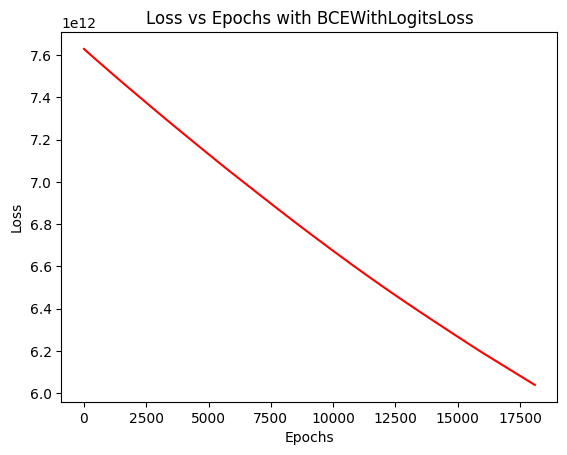

38338392064.0 6040010096640.0


In [33]:
import matplotlib.pyplot as plt
import numpy as np
# temp = Losses
# for i in temp:
#     if i >1.5:
#         temp.remove(i)
# print(temp)
# print(np.argmin(np.array(saved_model_losses)))
plt.plot(Losses[1900:], label = "Training Loss", color = 'red')
# plt.plot(Accuracies, label = "Training Accuracy", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs with BCEWithLogitsLoss")
plt.show()
print(Losses[0], Losses[-1])
print(Losses)

In [16]:
acchulu = ['అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ౠ', 'ఌ', 'ౡ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'అం', 'అః']
hallulu = ['క', 'ఖ', 'గ', 'ఘ', 'ఙ',
           'చ', 'ఛ', 'జ', 'ఝ', 'ఞ',
           'ట', 'ఠ', 'డ', 'ఢ', 'ణ',
           'త', 'థ', 'ద', 'ధ', 'న',
           'ప', 'ఫ', 'బ', 'భ', 'మ',
           'య', 'ర', 'ల', 'వ', 'శ', 'ష', 'స', 'హ', 'ళ', 'క్ష', 'ఱ', 'ఴ', 'ౘ', 'ౙ','ౚ']
vallulu = ['ా', 'ి', 'ీ', 'ు' , 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', 'ం', 'ః', 'ఁ', 'ఀ', 'ఄ', 'ౕ', 'ౖ', 'ౢ' ]
connector = ['్']
numbers = ['౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯']
splcharacters= [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')',
              '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[',
              '\\', ']', '^', '_', '`', '{', '|', '}', '~', '1','2', '3', '4', '5', '6', '7', '8', '9', '0', 'ఽ']
spl = splcharacters + numbers
bases = acchulu + hallulu + spl
vms = vallulu
cms = hallulu
characters = bases+vms+cms+connector
base_mapping = {}
i = 1
for x in bases:
  base_mapping[x] = i
  i+=1
vm_mapping = {}
i = 1
for x in vms:
  vm_mapping[x] = i
  i+=1
cm_mapping = {}
i = 1
for x in cms:
  cm_mapping[x] = i
  i+=1
def One_Hot_Decoder(List):
  x = ""
  for onehoti in List:
    for i in range(0, 112):
      if onehoti[i+2] == 1:
        x += bases[i]
    for i in range(133, 173):
      if onehoti[i+2] == 1:
        x += connector[0] 
        x += cms[i-133]
    for i in range(112,133):
      if onehoti[i+2] == 1:
        x += vms[i-112]
  return x

In [17]:
class NetworkPredict(nn.Module):
    def __init__(self) -> None:
        super(NetworkPredict, self).__init__()
         # embedding layer sizes
        self.einput_size = Joiner_Input_size #175
        self.eoutput_size = Joiner_output_size #300
        
        # LSTM parameters
        self.embed_size = LSTM_Input_size #300
        self.hidden_size = LSTM_hidden_size #300
        self.num_layers = LSTM_num_layers #1
        
        # reverse embedding layer sizes
        self.Rinput_size = Reverse_Input_size #300
        self.Routput_size = Reverse_output_size #175

        # dense embedding layers from 175 to 300
        self.embedding1 = nn.Linear(self.einput_size, self.eoutput_size, bias=False)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size = self.embed_size, 
                            hidden_size = self.hidden_size*2, 
                            num_layers = self.num_layers, 
                            dropout = drop_prob,
                            bidirectional = True,
                            bias = True,
                            batch_first=True)

        # attention layers
        self.attention_Q = nn.Linear(4*self.Rinput_size, 4*self.Rinput_size)
        self.attention_K = nn.Linear(4*self.Rinput_size, 4*self.Rinput_size)
        self.attention_V = nn.Linear(4*self.Rinput_size, 4*self.Rinput_size)

        # dense layers from 4000 to 175
        self.Dense1 = nn.Linear(4*self.Rinput_size, self.Routput_size)

    def init_hidden(self, batch_size):
        return (torch.zeros(2*self.num_layers, batch_size, 2*self.hidden_size).to(device),
                torch.zeros(2*self.num_layers, batch_size, 2*self.hidden_size).to(device))

    def forward(self, images):
        F_onehot = []

        self.hidden = self.init_hidden(1)

        hidden, c = self.lstm(images)

        # attention 
        Q = self.attention_Q(hidden)
        K = self.attention_K(hidden)
        V = self.attention_V(hidden)

        scores = torch.bmm(Q, K.transpose(1, 2))/ (self.Rinput_size ** (0.5))
        attention = F.softmax(scores, dim=2)
        outputs = torch.bmm(attention, V)

        outputs = self.Dense1(outputs)
        outputs = F.sigmoid(outputs)
        outputs = torch.round(outputs)

        F_onehot.append(outputs)
        # print(outputs)
        ind = 0
        while True:
            if(ind == 350): break
            ind += 1
            print(ind)
            outputs = self.embedding1(outputs)
            outputs = torch.concat((images, outputs[:, :-1, :]), dim=1)
            hidden, c = self.lstm(outputs)

            # attention 
            Q = self.attention_Q(hidden)
            K = self.attention_K(hidden)
            V = self.attention_V(hidden)

            scores = torch.bmm(Q, K.transpose(1, 2))/ (self.Rinput_size ** (0.5))
            attention = F.softmax(scores, dim=2)
            outputs = torch.bmm(attention, V)

            outputs = self.Dense1(outputs)
            outputs = F.sigmoid(outputs)
            outputs = torch.round(outputs)
            F_onehot.append(outputs)
            if(outputs[0][0][1] == 1):
                break
        

        return torch.stack(F_onehot)


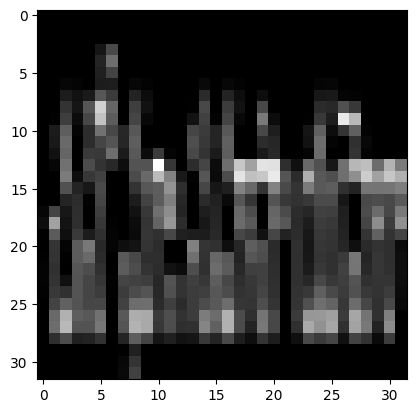

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
(350, 175)
actual:  చనో ఘాః సహసా యహో


In [18]:
import torch
import matplotlib.pyplot as plt

# cnn_predict = EncoderCNN().to(device)
# network_predict = NetworkPredict().to(device)

i = 1
# # load the model
# cnn_predict.load_state_dict(torch.load('/home/ocr/teluguOCR/Good_CNN_80_epochs.pt'))
# network_predict.load_state_dict(torch.load('/home/ocr/teluguOCR/Good_Network_80_epochs.pt'))

# cnn_predict.eval()
# network_predict.eval()

Images = "/home/ocr/teluguOCR/Dataset/NoisedImages/Tensor"
Labels = '/home/ocr/teluguOCR/Dataset/Label_tensors/Label_Tensor'

Image = torch.load(Images  + str(30) + ".pt")[10]
lines = torch.load(Labels  + str(30) + ".pt")[10]

plt.imshow(Image[0], cmap = 'gray')
plt.show()

# features = cnn_predict(Image.unsqueeze(0).to(device))
# features = features.unsqueeze(0)
# print(features.shape)
# predictions = network_predict(features)


# predictions = torch.round(torch.sigmoid(predictions))

# predictions = predictions.reshape(predictions.shape[0], predictions.shape[3])

# f_out = predictions.cpu().detach().numpy()
lines = lines.cpu().detach().numpy()
# starting_token = starting_token.cpu().detach().numpy()

# print(f_out[1])
print(lines[1])

# print(f_out.shape)
print(lines.shape)

# for i in range(350):
#     if(f_out[i][0] == 1):
#         print(i, " : ", "starting token")
#     if(f_out[i][1] == 1):
#         print(i, " : ", "ending token")

# print("predicted: ", One_Hot_Decoder(f_out))
print("actual: ", One_Hot_Decoder(lines))
      

In [19]:
    # f.write("training-1")
    # print("training-1")
    # Loss += combined_model.train(X_train[:200], y_train[:200], Epochs=1, f = f)

    # f.write("training-2")
    # print("training-2")
    # Loss += combined_model.train(X_train[200:400], y_train[200:400], Epochs=1, f = f)

    # f.write("training-3")
    # print("training-3")
    # Loss += combined_model.train(X_train[400:600], y_train[400:600], Epochs=1, f = f)

    # f.write("training-4")
    # print("training-4")
    # Loss += combined_model.train(X_train[600:], y_train[600:], Epochs=1, f = f)    

    # SM = nn.Softmax(dim=1)
    # f.write("testing")
    # print("testing")
    # cnt = 0
    # y_pred = torch.zeros(200, 350, 302)
    # for i in range(200):
    #   y_pred[i] = combined_model.forward(X_test[i].reshape((1, 62, 496)), y_test[i])
    #   y_pred[i] = y_pred[i].reshape(350, 302)
        
    #   y_pred[i][:113] = SM(y_pred[i][:113])
    #   y_pred[i][113:135] = SM(y_pred[i][113:135])
    #   y_pred[i][135:176] = SM(y_pred[i][135:176])
    #   y_pred[i][176:217] = SM(y_pred[i][176:217])
    #   y_pred[i][217:] = SM(y_pred[i][217:])

    #   if torch.all(y_pred[i].to(device=device) == y_test[i].to(device=device)):
    #     cnt += 1
    # f.write("testing done")
    # print("testing done")
    # print("correct predictions : ", cnt , " / " , 200)
    # print("accuracy : ", nn.BCELoss()(y_pred, y_test).item())
    # if(i%5 == 0):

In [20]:
# class LSTMByHand(pl.LightningModule):
#   def __init__(self):
#     # creates weights and biases
#     super().__init__()
#     mean = torch.tensor(0.0)
#     std = torch.tensor(1.0)

#     self.wlr1 =nn.parameter(torch.normal(mean, std), requires_grad = True)
#     self.wlr2 =nn.parameter(torch.normal(mean, std), requires_grad = True)
#     self.blr1 =nn.parameter(torch.tensor(0.0), requires_grad = True)

#     self.wpr1 =nn.parameter(torch.normal(mean, std), requires_grad = True)
#     self.wpr2 =nn.parameter(torch.normal(mean, std), requires_grad = True)
#     self.bpr1 =nn.parameter(torch.tensor(0.0), requires_grad = True)

#     self.wp1 =nn.parameter(torch.normal(mean, std), requires_grad = True)
#     self.wp2 =nn.parameter(torch.normal(mean, std), requires_grad = True)
#     self.bp1 =nn.parameter(torch.tensor(0.0), requires_grad = True)

#     self.wo1 =nn.parameter(torch.normal(mean, std), requires_grad = True)
#     self.wo2 =nn.parameter(torch.normal(mean, std), requires_grad = True)
#     self.bo1 =nn.parameter(torch.tensor(0.0), requires_grad = True)



#   def LSTM_unit(self, input_value , long_memory, short_memory):
#     # Do the LSTM Math
#     long_remember_percent = torch.sigmoid((short_memory*self.wlr1) + (input_value*self.wlr2) + self.blr1)

#     potential_remember_percent = torch.sigmoid((short_memory*self.wpr1) + (input_value*self.wpr2) + self.bpr1)
#     potential_memory = torch.tanh((short_memory*self.wp1) + (input_value*self.wp2) + self.bp1)

#     updated_long_memory = ((long_memory * long_remember_percent) + (potential_memory * potential_remember_percent))

#     output_percent = torch.sigmoid((short_memory * self.wo1) + (input_value * self.wo2) + self.bo1)
#     updated_short_memory = torch.tanh(updated_long_memory) * output_percent

#     return ([updated_long_memory, updated_short_memory])


#   def forward(self, input):
#     # forward pass
#     long_memory = input["Image"]
#     short_memory = 0

#     s_input = '$' + input["str"] [:-1]

#     [long_memory, short_mempry] = self.lstm_unit(s_input[:], long_memory, short_memory)

#     return short_memory



#   def configure_optimizers(self):
#     # configure adam optimizer
#     return Adam(self.parameters)

#   def training_step(self, batch, batch_idx):
#     # Calculate loss and log training process.
#     input_i, label_i = batch
#     output_i = self.forward(input_i[0])
#     loss = (output_i - label_i)**2

#     self.log("train_loss", loss)

#     return loss

In [21]:
# class CNNImageVectorizer(nn.Module):
#     def __init__(self, input_channels, output_size):
#         super(CNNImageVectorizer, self).__init__()

#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(1),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(1),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 400, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(1),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )

#         self.flatten = nn.Flatten()

#         # Embedding layer
#         self.embedding_layer = nn.Linear(400 * (28 // 8) * (64 // 8), output_size)

#     def forward(self, x):
#         x = self.conv_layers(x)
#         # print(x.shape)
#         x = x.reshape(400*8*3)
#         # print(x.shape)
#         x = self.embedding_layer(x)
#         return x

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=0.01)

In [22]:
# class AttentionLayer(nn.Module):
#     def __init__(self, img_embedding_size, lstm_hidden_size):
#         super(AttentionLayer, self).__init__()
#         self.W1 = nn.Linear(img_embedding_size + 2*lstm_hidden_size, 1600)
#         self.V = nn.Linear(1600, 2*lstm_hidden_size + img_embedding_size)

#     def forward(self, img_embedding, lstm_hidden):
#         input = torch.cat((img_embedding.reshape(400), lstm_hidden.reshape(800)), dim=0)
#         output = torch.tanh(self.W1(input))
#         output = nn.Softmax(dim=0)(self.V(output))
#         h0 = output[0:800]
#         h0 = h0.reshape(2, 400)
#         img = output[800:1600]
#         img = img.reshape(1, 400)
        
#         return h0, img



In [23]:
# class Network(nn.Module):
#     def __init__(self, input_d, hidden_d, layer_d, output_d):
#         super(Network, self).__init__()
#         self.hidden_dim = hidden_d
#         self.layer_dim = layer_d
#         self.lstm = nn.LSTM(input_d + hidden_d, hidden_d, layer_d, batch_first=True, bidirectional=True).to(device)
#         self.fc = nn.Linear(2*hidden_d, output_d)
#         self.attention = AttentionLayer(hidden_d, hidden_d)

#     def forward(self, img, x, h0 = None, c0 = None):
#         if h0 is None:
#           h0 = torch.zeros(self.layer_dim * 2, self.hidden_dim, device=device, requires_grad=True)
#         if c0 is None:
#           c0 = torch.zeros(self.layer_dim * 2, self.hidden_dim, device=device, requires_grad=True)
        
#         # shapes: img: (1, 400), x: (302), h0: (2, 400), c0: (2, 400)
#         h0 = h0.reshape(2*self.hidden_dim)
#         h0, img_1 = self.attention(img, h0)
#         h0 = h0.reshape(2, self.hidden_dim)
        
#         x = torch.cat((x, img_1.reshape(self.hidden_dim)), dim=0)
#         x = x.unsqueeze(0)
#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

#         out1 = self.fc(out).to(device)
#         return out1, hn,  cn

#     def configure_optimizers(self):
#      return Adam(self.parameters(), lr = 0.01)

In [24]:
# class Joiner(nn.Module):
#     def __init__(self) -> None:
#         super(Joiner, self).__init__()
#         self.input_size = Joiner_Input_size
#         self.output_size = Joiner_output_size
#         self.hidden_size = Joiner_hidden_size
#         self.fc1 = nn.Linear(self.input_size, self.hidden_size)
#         # self.fc1.weight.data.normal_(200, 5)
#         # self.fc1.bias.data.fill_(0)
#         # self.sig1 = nn.Sigmoid()
#         self.fc2 = nn.Linear( self.hidden_size, self.output_size)
#         # self.fc2.weight.data.normal_(200, 5)
#         # self.fc2.bias.data.fill_(0)
#         # self.sig2 = nn.LeakyReLU(1)
    
#     def forward(self, img_embedding, text_embedding):
#         img_embedding = img_embedding.reshape(Image_embedding_size)
#         text_embedding = text_embedding.reshape(Text_embedding_size)
#         x = torch.cat((img_embedding, text_embedding), dim=0)
#         x = self.fc1(x)
#         # x = self.sig1(x)
#         x = self.fc2(x)
#         # x = self.sig2(x)
#         return x

In [25]:
# class LSTM(nn.Module):
#     def __init__(self) -> None:
#         super(LSTM, self).__init__()
#         self.embed_size = Image_embedding_size
#         self.hidden_size = LSTM_hidden_size
#         self.num_layers = LSTM_num_layers
#         self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
#         # self.lstm.all_weights[0][0].data.normal_(0.0, 0.02)
#         # self.fc = nn.Linear(self.hidden_size*2, LSTM_output_size)
#         # self.fc.weight.data.random_(-0.5, 0.5, generator=None)
#         # self.fc.bias.data.fill_(0)

#     def forward(self, x, h0, c0):
#         if h0 is None:
#           h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device, requires_grad=True)
#         if c0 is None:
#             c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device, requires_grad=True)
        
#         # print(x.shape)
#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
#         # out = self.fc(out)
#         return out, hn, cn
        

In [26]:
# # Model after LSTM. It takes the output of the LSTM and generates the final output.
# class Inner(nn.Module):
#     def __init__(self) -> None:
#         super(Inner, self).__init__()
#         self.input_size = LSTM_output_size
#         self.output_size = Text_embedding_size
#         self.hidden_size = Inner_hidden_size

#         self.fc = nn.Linear(self.input_size, self.hidden_size)
#         self.fc.weight.data.uniform_(-0.1, 0.1)
#         # self.fc.bias.data.fill_(0)
#         # self.sig1 = nn.Tanh()
#         self.fc1 = nn.Linear(self.hidden_size, self.output_size)
#         self.fc1.weight.data.uniform_(-0.1, 0.1)
#         # self.fc1.bias.data.fill_(0)
#         # self.sig2 = nn.LeakyReLU(1)

#     def forward(self, x):
#         # print(x.shape)
#         x = self.fc(x)
#         # x = self.sig1(x)
#         x = self.fc1(x)
#         # x = self.sig2(x)
#         return x        

In [27]:
# class CNNLSTMModel(nn.Module):
#     def __init__(self, cnn, Network):
#         super(CNNLSTMModel, self).__init__()
#         self.cnn = cnn
#         self.network = Network
#         self.SM = nn.Softmax(dim=1)

#     # Teacher foring for training
#     def forward(self, images, labels):
#         images = images.to(device)
#         labels = labels.to(device)
        
#         cnn_output = self.cnn.forward(images.reshape(( batch_size, Image_size[2], Image_size[0], Image_size[1]))).to(device)

#         F_output = torch.zeros((Max_Number_of_Words, Text_embedding_size)).to(device)
#         lstm_output = self.network.forward(cnn_output.reshape((batch_size, 1, Image_embedding_size)), None, first = True)
#         F_output[0] = lstm_output
#         for i in range(Max_Number_of_Words):
#             if(torch.all(labels[i] == 0)):
#                 break
#             lstm_output = self.network.forward(cnn_output.reshape((batch_size, 1, Image_embedding_size)), label[i].reshape((1, 1, Text_embedding_size)), first=False)
#             F_output[i+1] = lstm_output
#         F_output = F_output.to(device)
#         return F_output
    
#     def configure_optimizers(self):
#         return optim.Adam(self.parameters(), lr=0.001)

#     def Epoch(self, Image, label, f = None):
#         criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
#         optim = self.configure_optimizers()
#         l = 0
#         loss = 0
        
#         for i in range(Number_of_images):
#             L = label[i:min(i + batch_size, Number_of_images)].to(device)
#             lstm_output = self.forward(Image[i:min(i + batch_size, Number_of_images)].reshape((min(i + batch_size, Number_of_images) - i, Image_size[0], Image_size[1], Image_size[2])), L).to(device)
#             lstm_output = lstm_output.reshape(Max_Number_of_Words, Text_embedding_size)
            
#             loss += criterion(lstm_output[:][:113], L[:][:113])
#             loss += criterion(lstm_output[:][113:135], L[:][113:135])
#             loss += criterion(lstm_output[:][135:157], L[:][135:157])
#             loss += criterion(lstm_output[:][157:179], L[:][157:179])
#             loss += criterion(lstm_output[:][179:220], L[:][179:220])
#             loss += criterion(lstm_output[:][220:261], L[:][220:261])
#             loss += criterion(lstm_output[:][261:], L[:][261:])   

#             optim.zero_grad()
#             loss.backward()
#             optim.step()
#             l += loss.item()
#         return l

In [28]:
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torchvision import models

# Image_size = (224, 224, 3)

# class EncoderCNN(nn.Module):
#     def __init__(self) -> None:
#         super(EncoderCNN, self).__init__()
#         # input: 224*224*3
#         resnet = models.resnet50(pretrained=True)
#         for param in resnet.parameters():
#             param.requires_grad_(False)
        
#         modules = list(resnet.children())[:-1]
#         self.resnet = nn.Sequential(*modules)
#         self.embed = nn.Linear(resnet.fc.in_features, Image_embedding_size)
#         self.batch= nn.BatchNorm1d(Image_embedding_size,momentum = 0.01)
#         self.embed.weight.data.normal_(0., 0.02)
#         self.embed.bias.data.fill_(0)

#     def forward(self, x):
#         # 224*224*3
#         x = self.resnet(x) # 2048
#         x = x.view(x.size(0), -1)
#         x = self.embed(x)
#         x = self.batch(x)
#         return x

#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=0.01)
#         return optimizer


లోకేషు వర్తమానానాం పుంసాం తేన చ హేతునా
(496, 29)


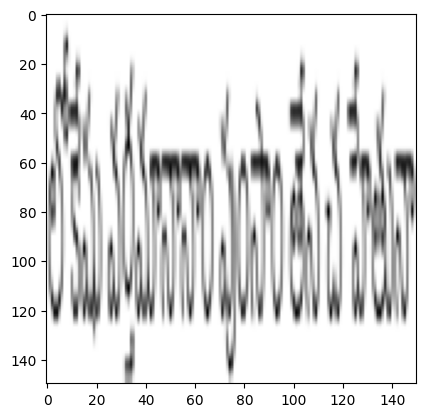

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
i = 120
I = Image.open("/home/ocr/teluguOCR/Dataset/Images_of_texts/Image_" + str(i) + ".png")
label = read_file_lines("/home/ocr/teluguOCR/Dataset/labels.txt")
print(label[i-1])
print(I.size)
I = I.resize((150, 150))
plt.imshow(I, cmap='gray')
plt.show()

In [30]:
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torchvision import models

# class EncoderCNN(nn.Module):
#     def __init__(self):
#         super(EncoderCNN, self).__init__()
#         resnet = models.resnet34(pretrained=True)
#         for param in resnet.parameters():
#             param.requires_grad_(False)
        
#         modules = list(resnet.children())[:-1]
#         self.resnet = nn.Sequential(*modules)
#         self.Linear = nn.Linear(resnet.fc.in_features, Image_embedding_size)
        

#     def forward(self, x):
#         # Input size: (batch_size, 3, 300, 300)
#         x = self.resnet(x)
#         # Output size: (batch_size, 2048, 1, 1)
#         x = x.view(x.size(0), -1)
#         # Output size: (batch_size, 2048)
#         x = self.Linear(x)

#         return x

#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=0.01)
#         return optimizer
